In [10]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from numpy import pi
import torch
import cv2
import time

In [11]:
pathMesh = "large-size-data/Final_refined_Mesh.stl"
FinalRefinedMesh = o3d.io.read_triangle_mesh(pathMesh)
FinalRefinedMesh.remove_duplicated_vertices()
FinalRefinedMesh.remove_duplicated_triangles()

Vertices = np.asarray(FinalRefinedMesh.vertices)
TrianglesIndex = np.asarray(FinalRefinedMesh.triangles)
Triangles = Vertices[TrianglesIndex]

In [12]:
def Custom_Visualizer_Mesh(obj):
    width=1820
    vis = o3d.visualization.Visualizer()
    vis.create_window('Open3D', width, height=980,
                      left=int(0.5*(1920-width)), top=35, visible=True)
    vis.add_geometry(obj)

    RenderOpt = vis.get_render_option()
    RenderOpt.show_coordinate_frame= True
    RenderOpt.mesh_show_wireframe = True
    
    # RenderOpt.PointColorOption = 9
    # obj.vertex_colors = obj.vertex_normals
    RenderOpt.mesh_color_option = o3d.visualization.MeshColorOption.ZCoordinate
    
    #print(dir(RenderOpt.mesh_color_option.Color.ZCoordinate))
    #obj.paint_uniform_color([1, 0.706, 0])
    # img = vis.capture_screen_float_buffer(True)
    
    vis.run()
    vis.destroy_window()
    return 

Custom_Visualizer_Mesh(FinalRefinedMesh)

In [13]:
def Rotation_Matrix(pitch_x, heading_y, roll_z):

    from numpy.linalg import multi_dot

    theta = np.array([pitch_x, heading_y, roll_z])*(pi/180)
    R_pitch_x = np.array([[1,         0,                  0                ],
                          [0,         np.cos(theta[0]),  -np.sin(theta[0]) ],
                          [0,         np.sin(theta[0]),   np.cos(theta[0]) ] ])

    R_heading_y = np.array([[np.cos(theta[1]),    0,      np.sin(theta[1])  ],
                            [0,                     1,      0                   ],
                            [-np.sin(theta[1]),   0,      np.cos(theta[1])  ]
                            ])

    R_roll_z = np.array([[np.cos(theta[2]),    -np.sin(theta[2]),    0],
                        [np.sin(theta[2]),    np.cos(theta[2]),     0],
                        [0,                     0,                      1]
                        ])

    RotationMatrix = multi_dot([ R_roll_z, R_heading_y,  R_pitch_x])   
    
    return RotationMatrix

def OpenGLandCV_to_Open3D_Angles_deg(OpenGLandCV_angles):
    Coordinate_Rotate = Rotation_Matrix(180,0,0).round(1)
    OP3D_angles = np.matmul(Coordinate_Rotate, OpenGLandCV_angles)-np.array([180,0,0])
    return OP3D_angles

def Open3D_to_OpenGLandCV_Angles_deg(OP3D_angles):
    Coordinate_Rotate = Rotation_Matrix(180,0,0).round(1)
    OpenGLCV_angles = np.matmul(Coordinate_Rotate, OP3D_angles)+np.array([180,0,0])
    return OpenGLCV_angles

In [14]:
def TorchRotationMatrix(axis: str, angle):
  cos = torch.cos(angle)
  sin = torch.sin(angle)
  one = torch.ones_like(angle)
  zero = torch.zeros_like(angle)


  if axis == "X":
    R_flat = (one, zero, zero, zero, cos, -sin, zero, sin, cos)
  if axis == "Y":
    R_flat = (cos, zero, sin, zero, one, zero, -sin, zero, cos)
  if axis == "Z":
    R_flat = (cos, -sin, zero, sin, cos, zero, zero, zero, one)
  return torch.stack(R_flat, -1).reshape((3, 3))

def TorchEulerAnglesToRotationMatrixDegree(theta):

  R_x = TorchRotationMatrix("X", theta[0])
  R_y = TorchRotationMatrix("Y", theta[1])
  R_z = TorchRotationMatrix("Z", theta[2])

  return torch.matmul(R_z, torch.matmul(R_y, R_x))

def TorchProjection(PointCloud,
               Cam_x, Cam_y, Cam_z,
               theta1, theta2, theta3,
               FL_x, FL_y,
               camera_center, Image_height):    # Pointcloud, Cam_xyz, theta123, 
  
  import torch
  import numpy as np
  from math import pi
  
  N_p = PointCloud.shape[0]

  Cam_pos = torch.stack((Cam_x, Cam_y, Cam_z), -1)
  tvec = - Cam_pos

  THETA = torch.stack((theta1, theta2, theta3), -1)
  THETA_rad = THETA*(pi/180)
  RotMatrix = TorchEulerAnglesToRotationMatrixDegree(THETA_rad)

  focal_length = - torch.tensor((FL_x,FL_y), dtype=torch.float64)

  camera_matrix = torch.tensor([[focal_length[0], 0, camera_center[1]-0.5],
                                [0, focal_length[0], camera_center[0]-0.5],
                                [0, 0, 1]], dtype=torch.float64)
  

  Translated = (PointCloud + tvec)
  xyz = torch.bmm(RotMatrix.repeat(N_p,1).reshape(N_p,3,3), Translated.reshape(N_p,3,1))
  xyz_prime = xyz / xyz[:,2].unsqueeze(1)
  uv = torch.bmm(camera_matrix.repeat(N_p,1).reshape(N_p,3,3), xyz_prime).reshape(N_p,3)


  Y_invert = torch.tensor([1, -1, 1], dtype=torch.float64).repeat(N_p,1)
  Y_invert_height = torch.tensor([0, Image_height, 0]).repeat(N_p,1)

  uv_final = ((uv * Y_invert) + Y_invert_height)[:,0:2]
  return uv_final

In [15]:
def Model_View_Matrix(Cam_x, Cam_y, Cam_z, pitch_x, heading_y, roll_z):

    from numpy.linalg import multi_dot

    tvec = - np.array([Cam_x, Cam_y, Cam_z]) 

    M_trans_H = np.identity(4)
    M_trans_H[0:3,-1] = tvec

    theta = np.array([pitch_x,heading_y,roll_z])*(pi/180)

    R_pitch_x = np.array([[1,         0,                  0                ],
                          [0,         np.cos(theta[0]),  -np.sin(theta[0]) ],
                          [0,         np.sin(theta[0]),   np.cos(theta[0]) ] ])


    R_heading_y = np.array([[np.cos(theta[1]),    0,      np.sin(theta[1])  ],
                            [0,                     1,      0                   ],
                            [-np.sin(theta[1]),   0,      np.cos(theta[1])  ]
                            ])

    R_roll_z = np.array([[np.cos(theta[2]),    -np.sin(theta[2]),    0],
                        [np.sin(theta[2]),    np.cos(theta[2]),     0],
                        [0,                     0,                      1]
                        ])

    R_pitch_x_H = np.concatenate( (np.concatenate((R_pitch_x, np.array([[0],[0],[0]])), axis=1),
                     np.array([[0,0,0,1]])), axis=0)
    R_heading_y_H = np.concatenate( (np.concatenate((R_heading_y, np.array([[0],[0],[0]])), axis=1),
                     np.array([[0,0,0,1]])), axis=0)
    R_roll_z_H = np.concatenate( (np.concatenate((R_roll_z, np.array([[0],[0],[0]])), axis=1),
                     np.array([[0,0,0,1]])), axis=0)

    ViewMatrix = multi_dot([ R_roll_z_H, R_heading_y_H,  R_pitch_x_H, M_trans_H])   
    ModelMatrix = np.identity(4)
    Model_View_Matrix = np.matmul(ViewMatrix, ModelMatrix)

    return Model_View_Matrix   

In [16]:
def Custom_Visualizer_CameraPose_FOV_Complete(obj,
                                              Cam_x, Cam_y, Cam_z,
                                              pitch_x, heading_y, roll_z,
                                              fov, Width_img, Height_img):
            
    
    Extrinsic_H = Model_View_Matrix(Cam_x, Cam_y, Cam_z,
                  pitch_x, heading_y, roll_z)
    
    
    vis = o3d.visualization.Visualizer()
    vis.create_window('camera_view', Width_img, Height_img,
                      left=int(0.5*(2496-Width_img)), top=55, visible=True)
    vis.add_geometry(obj)

    view_ctl = vis.get_view_control()  # Everything good
    
    fov_add = (fov-60)/5.
    #print(view_ctl.get_field_of_view())
    view_ctl.change_field_of_view(step=fov_add)
    #print(view_ctl.get_field_of_view())
    
    cam = view_ctl.convert_to_pinhole_camera_parameters()
  
    cam.extrinsic = Extrinsic_H  
    

    
    view_ctl.convert_from_pinhole_camera_parameters(cam, allow_arbitrary=True)
    
    
    
    RenderOpt = vis.get_render_option()
    RenderOpt.show_coordinate_frame= True
    RenderOpt.mesh_show_wireframe = True
    RenderOpt.mesh_color_option = o3d.visualization.MeshColorOption.ZCoordinate
    
    
    
    
    #vis.update_geometry()
    depth = vis.capture_depth_float_buffer(True)
    depth_image = np.asarray(depth)
    z_image = depth_image #* 1000  # Scale if needed
    # plt.imshow(z_image, cmap='viridis')
    # plt.colorbar()
    # plt.show()
    
    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image('./zImage2024.jpeg')
    
    img = vis.capture_screen_float_buffer(True)
    
    vis.run()
    vis.destroy_window()
    

    return view_ctl, img, z_image

In [17]:
OCV_Angles = np.array([271.0925953715764, -62.48613420432155 ,  -0.8450780191918068])
O3D_Angles = OpenGLandCV_to_Open3D_Angles_deg(OCV_Angles)


CPose_x = 649342.8824456889
CPose_y = 142747.35621634117
CPose_z = 2858.5893565840506

CPose_pitch_x = O3D_Angles[0]
CPose_heading_y = O3D_Angles[1]
CPose_roll_z = O3D_Angles[2]

ImageWidth = 961
ImageHeight = 418 
FOV = 26.620013724736527

Loc = np.array([CPose_x, CPose_y, CPose_z])
Angles = np.array([CPose_pitch_x, CPose_heading_y, CPose_roll_z])

#################################################################

cam_x = torch.tensor(CPose_x, dtype=torch.float64)
cam_y = torch.tensor(CPose_y, dtype=torch.float64)
cam_z = torch.tensor(CPose_z, dtype=torch.float64)

theta1 = torch.tensor(Open3D_to_OpenGLandCV_Angles_deg(Angles)[0], dtype=torch.float64)
theta2 = torch.tensor(Open3D_to_OpenGLandCV_Angles_deg(Angles)[1], dtype=torch.float64)
theta3 = torch.tensor(Open3D_to_OpenGLandCV_Angles_deg(Angles)[2], dtype=torch.float64)

ViewAngle = torch.tensor(FOV, dtype=torch.float64)

Imagesize = (ImageWidth, ImageHeight)
camera_center=(ImageHeight/2, ImageWidth/2)

fl_x = (Imagesize[1])/(2*torch.tan((ViewAngle/2)*(pi/180.)))
fl_y = (Imagesize[0])/(2*torch.tan((ViewAngle/2)*(pi/180.)))

In [18]:
CamParams, renderedIMG, depthimage = Custom_Visualizer_CameraPose_FOV_Complete(FinalRefinedMesh,
                                                      Loc[0],Loc[1],Loc[2],
                                                      Angles[0],Angles[1],Angles[2],
                                                      FOV, ImageWidth, ImageHeight)

(418, 961, 3)


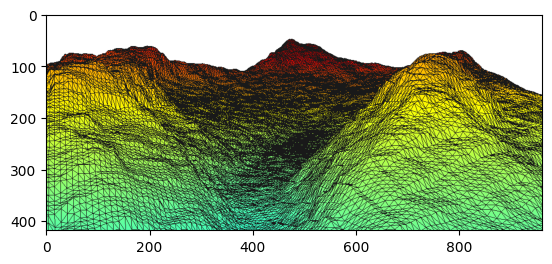

In [19]:
plt.imshow(renderedIMG)
print(np.array(renderedIMG).shape)
plt.show()

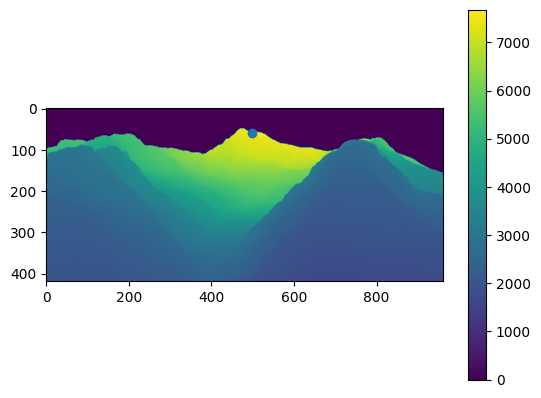

(418, 961)
[ 58 499]


In [20]:
plt.imshow(depthimage)
plt.colorbar()
maxdepth_point = np.array(np.unravel_index(depthimage.argmax(), depthimage.shape))
plt.scatter(maxdepth_point[1], maxdepth_point[0])
plt.show()
print(depthimage.shape)
print(maxdepth_point)

In [21]:
# These are from optimization performed in Gdrive Colab notebook Mountain_SGD_PyTorch5-V2.ipynb 

xyzPoints = torch.tensor([[642567.9665594,  146187.89045502,   4122.],
                          [646267.95169768, 145812.89196128,   3389.]]).to(torch.float64)
ProjectedPoints = torch.tensor([[470.60234849,  54.61093811],
                                [756.95409002,  87.88473449]]).to(torch.float64)

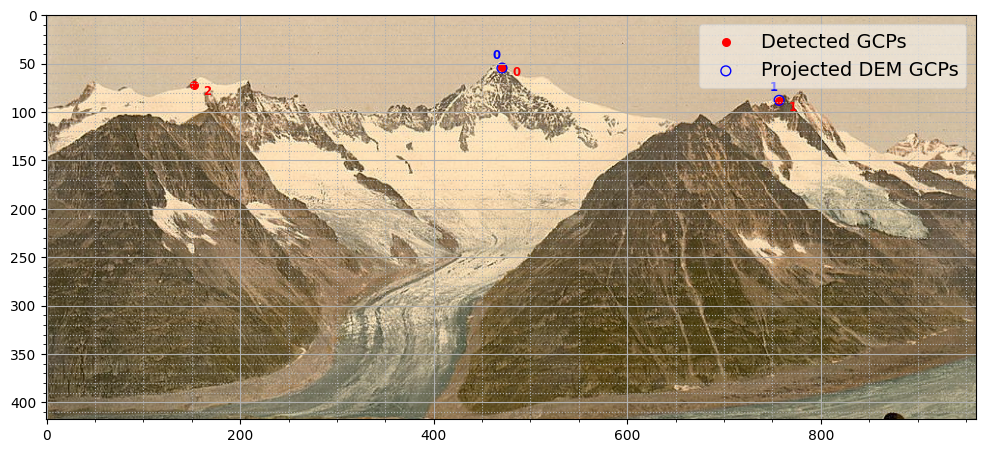

[[471.  53.]
 [757.  89.]]


In [24]:
Image_keypoints = np.loadtxt('data/ORB_imageKeyPoints.out',
                             delimiter=',').round()
listSelectedImgKeyPnts = [23 , 30, 49]
Selected_Image_keypoints = Image_keypoints[listSelectedImgKeyPnts]

Mnt_img = cv2.imread('data/Mountain_cropped.jpg')
width_Mnt_img = Mnt_img.shape[1]
height_Mnt_img = Mnt_img.shape[0]

fig= plt.figure(figsize=(12,15))
plt.imshow(Mnt_img[:,:,::-1])
plt.scatter(Selected_Image_keypoints[:,0], Selected_Image_keypoints[:,1], s=30, c='r', label='Detected GCPs')
plt.scatter(ProjectedPoints.numpy()[:,0], ProjectedPoints.numpy()[:,1], s=50,  facecolors='none', edgecolors='b',
            alpha=1, label='Projected DEM GCPs') #c='b',
plt.axis('scaled')

# plt.xlim(-1.5*width_img,width_img*1.5)
# plt.ylim(-1.5*height_img,height_img*1.5)

# plt.xlim(0, width_img)
# plt.ylim(height_img, 0)
# plt.gca().invert_yaxis()

for i in range(Selected_Image_keypoints.shape[0]):
    margin = 10   #Selected_Geo_Keypoints[i,0]*0.05
    plt.text(Selected_Image_keypoints[i,0]+margin,
             Selected_Image_keypoints[i,1]+margin,
             str(i),
             horizontalalignment='left', size='small', color='red', weight='semibold')

for i in range(ProjectedPoints.shape[0]):
    margin = -10   #Selected_Geo_Keypoints[i,0]*0.05
    plt.text(ProjectedPoints.numpy()[i,0]+margin,
             ProjectedPoints.numpy()[i,1]+margin,
             str(i),
             horizontalalignment='left', size='small', color='blue', weight='semibold')
    
plt.grid(which='major')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.legend(fontsize=14, framealpha=0.5)
plt.show()

print(Selected_Image_keypoints[0:2])

# BackProjection

In [25]:
xyzPoints = torch.tensor([[642567.9665594,  146187.89045502,   4122.],
                          [646267.95169768, 145812.89196128,   3389.]], dtype=torch.float64)
ProjectedPoints = torch.tensor([[470.60647862,  54.61139638],
                                [756.96153049,  87.88419325]], dtype=torch.float64)

In [39]:
TorchProjection(xyzPoints,
               cam_x, cam_y, cam_z,
               theta1, theta2, theta3,
               fl_x, fl_y,
               camera_center, ImageHeight).numpy()

array([[470.60647862,  54.61139638],
       [756.96153049,  87.88419325]])

In [40]:
def TorchBackProjection(image_uv_indices_, image_depth_O3D,
                        cam_x_, cam_y_, cam_z_,
                        theta1_, theta2_, theta3_,
                        fl_x_, fl_y_, camera_center_, ImageHeight_):
    
    uv_indices = image_uv_indices_.round().to(torch.int64).numpy()
    depthval = torch.tensor(image_depth_O3D[uv_indices[:, 1], uv_indices[:,0]].reshape(-1, 1), dtype=torch.float64)
    
    # image_uv_indices_ may be non-integer
    uv_indices_augmentedwithOnes = torch.tensor(np.hstack([image_uv_indices_, np.ones((uv_indices.shape[0], 1))]), dtype=torch.float64)

    N_p = image_uv_indices_.shape[0]
    Y_invert = torch.tensor([1, -1, 1], dtype=torch.float64).repeat(N_p,1)
    Y_invert_height = torch.tensor([0, ImageHeight_, 0]).repeat(N_p,1)

    uv_back = ((uv_indices_augmentedwithOnes - Y_invert_height)*Y_invert)
    uv_back_depth = uv_back*(-1*depthval)

    focal_length = - torch.tensor((fl_x_,fl_y_), dtype=torch.float64)

    camera_matrix = torch.tensor([[focal_length[0], 0, camera_center_[1]-0.5],
                                  [0, focal_length[0], camera_center_[0]-0.5],
                                  [0, 0, 1]], dtype=torch.float64)

    back2 = torch.bmm(torch.linalg.inv(camera_matrix).repeat(N_p,1).reshape(N_p,3,3), uv_back_depth.unsqueeze(2))

    THETA = torch.stack((theta1_, theta2_, theta3_), -1)
    THETA_rad = THETA*(pi/180)
    RotMatrix = TorchEulerAnglesToRotationMatrixDegree(THETA_rad)
    back3 = torch.bmm(torch.linalg.inv(RotMatrix).repeat(N_p,1).reshape(N_p,3,3), back2).squeeze(2)

    Cam_pos = torch.stack((cam_x_, cam_y_, cam_z_), -1)
    tvec = - Cam_pos
    xyz_backproj = (back3 - tvec)

    return xyz_backproj

In [41]:
xyzPoints_backProj = TorchBackProjection(ProjectedPoints, depthimage,
                                        cam_x, cam_y, cam_z,
                                        theta1, theta2, theta3,
                                        fl_x, fl_y, camera_center, ImageHeight)
RelPErr = (abs(xyzPoints - xyzPoints_backProj)/xyzPoints)*100
RelPErr.mean(dim=0)

tensor([0.0888, 0.3698, 2.8824], dtype=torch.float64)

In [42]:
xyzPoints_backProj = TorchBackProjection(ProjectedPoints.round(), depthimage,
                                        cam_x, cam_y, cam_z,
                                        theta1, theta2, theta3,
                                        fl_x, fl_y, camera_center, ImageHeight)
RelPErr = (abs(xyzPoints - xyzPoints_backProj)/xyzPoints)*100
RelPErr.mean(dim=0)

tensor([0.0890, 0.3688, 2.9275], dtype=torch.float64)

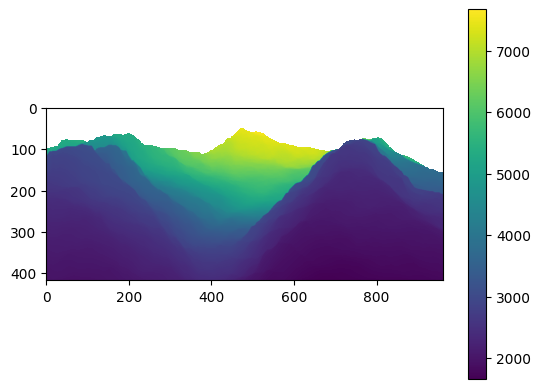

In [43]:
depthImg_nonZero = depthimage.copy()

depthImg_nonZero[depthImg_nonZero==0.0] = np.nan
plt.imshow(depthImg_nonZero)
plt.colorbar()
plt.show()

In [44]:
u_ind, v_ind = np.where(~np.isnan(depthImg_nonZero))
uv_indices_depthImg = torch.tensor(np.hstack([v_ind.reshape(-1,1), u_ind.reshape(-1,1)]))

In [45]:
xyzPoints_backProj_depthImge = TorchBackProjection(uv_indices_depthImg, depthimage,
                                        cam_x, cam_y, cam_z,
                                        theta1, theta2, theta3,
                                        fl_x, fl_y, camera_center, ImageHeight)

In [46]:
X_image = depthImg_nonZero.copy()
X_image[u_ind, v_ind] = xyzPoints_backProj_depthImge[:,0]

Y_image = depthImg_nonZero.copy()
Y_image[u_ind, v_ind] = xyzPoints_backProj_depthImge[:,1]

Z_image = depthImg_nonZero.copy()
Z_image[u_ind, v_ind] = xyzPoints_backProj_depthImge[:,2]

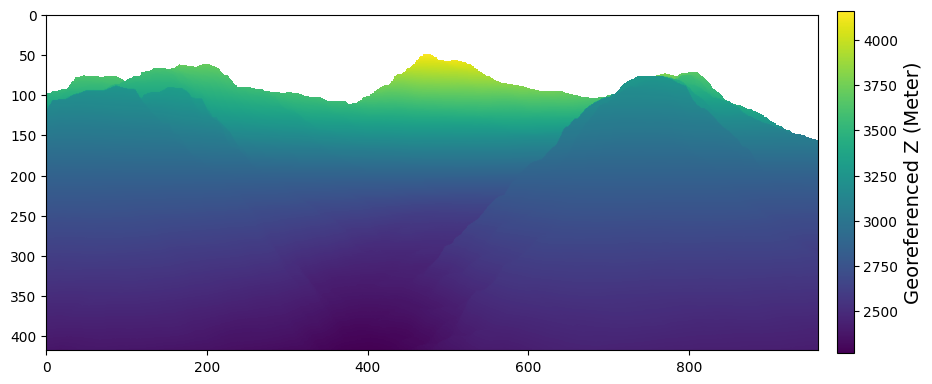

In [47]:
# plt.imshow(Z_image)
# print(Z_image.shape)
# plt.colorbar()
# plt.show()

fig= plt.figure(figsize=(12,12))

plt.imshow(Z_image)

cbar = plt.colorbar(shrink=0.370, pad=0.02)
cbar.set_label('Georeferenced Z (Meter)', rotation=90, fontsize=14)
plt.axis('scaled')

# plt.xlim(0,ImageWidth)
# plt.ylim(0,ImageHeight)
plt.savefig('data/Z_image.png', bbox_inches='tight', dpi=300)

plt.show()

In [48]:
snowmask = np.load('data/Mountain_cropped_binaryMask_snow.npy')

In [49]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 0/255, 0/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

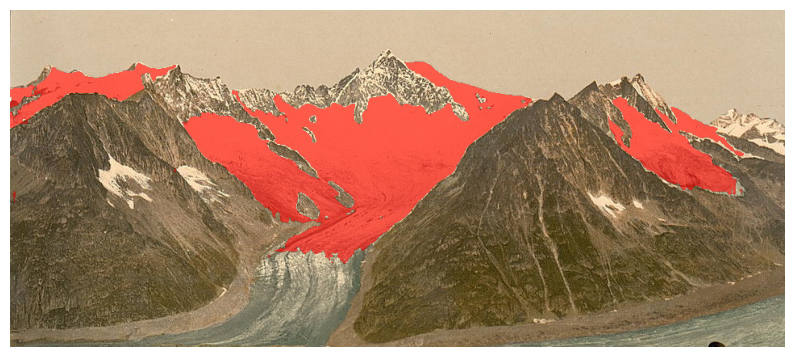

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(Mnt_img[:,:,::-1])
show_mask(snowmask, plt.gca())
plt.axis('off')
plt.savefig('data/snow_segmented_mountain.png', bbox_inches='tight', dpi=300)

plt.show()

In [51]:
u_ind_snow, v_ind_snow = np.where(snowmask)
uv_indices_snow = torch.tensor(np.hstack([v_ind_snow.reshape(-1,1), u_ind_snow.reshape(-1,1)]))

In [52]:
xyzPoints_backProj_snow = TorchBackProjection(uv_indices_snow, depthimage,
                                        cam_x, cam_y, cam_z,
                                        theta1, theta2, theta3,
                                        fl_x, fl_y, camera_center, ImageHeight)

In [53]:
xyzPoints_backProj_snow

tensor([[642818.3026, 146233.0163,   4001.4851],
        [642820.7475, 146241.1912,   4001.7154],
        [642839.2711, 146336.0064,   4005.7441],
        ...,
        [646368.4008, 144023.3215,   2448.4776],
        [646368.4191, 144027.2843,   2448.2392],
        [646368.4373, 144031.2516,   2448.0004]], dtype=torch.float64)

In [54]:
# gray_image = cv2.imread('../DEM analysis/DEM_Image_Gray_No_deletion.jpg', cv2.COLOR_BGR2GRAY)
# fig = plt.figure(figsize = (10, 6))
# plt.imshow(gray_image, cmap='viridis')

c:\Users\behza\miniconda3\envs\monoplot\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


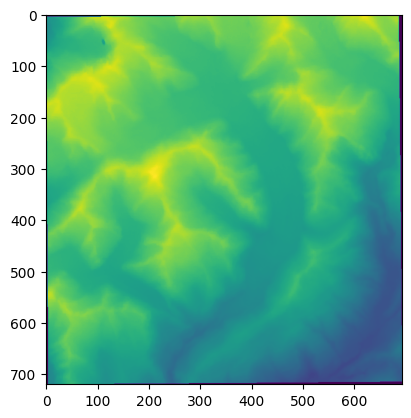

(720, 693)


In [55]:
from osgeo import gdal

filename = "data/AletschGlacierDEM.tiff"
gdata = gdal.Open(filename)

gdal_band = gdata.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()
raster = gdata.ReadAsArray()
GTransf = gdata.GetGeoTransform()
plt.imshow(raster)
plt.axis('scaled')
plt.show()
print(raster.shape)

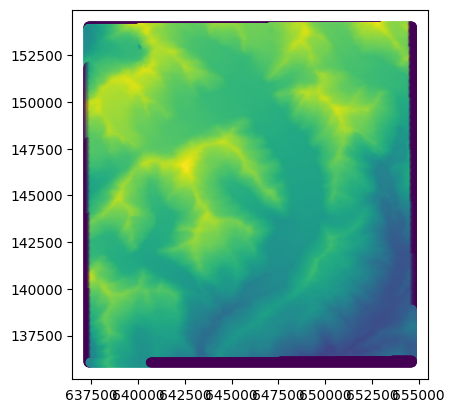

In [56]:
def Raster_pixel_to_XYZ(raster_, GTransform):

    g0 = GTransform[0]
    g1 = GTransform[1]
    g2 = GTransform[2]
    g3 = GTransform[3]
    g4 = GTransform[4]
    g5 = GTransform[5]
    
    points_ = []

    for j_vertical in range(raster_.shape[0]):
        for i_horizental in range(raster_.shape[1]):
            
            x= (i_horizental)*g1 + (j_vertical)*g2 + g0
            y= (i_horizental)*g4 + (j_vertical)*g5 + g3
            z= raster_[j_vertical, i_horizental]
            points_.append([x,y,z])
    points_ = np.array(points_)
    return points_

points = Raster_pixel_to_XYZ(raster, GTransf)
fig = plt.figure() #figsize = (12, 8)
plt.scatter(points[:,0],points[:,1], c=points[:,2])
plt.axis('scaled')
plt.show()

In [57]:
def XYZ_to_pixel_loc(XYZ, GTransform):
    g0 = GTransform[0]
    g1 = GTransform[1]
    g2 = GTransform[2]
    g3 = GTransform[3]
    g4 = GTransform[4]
    g5 = GTransform[5]

    X = XYZ[:,0]
    Y = XYZ[:,1]
    
    if g4 != 0:
        coeff = g1/g4
        j_vertical = ((X - coeff*Y) - (g0 - g3*coeff))/(g2 - g5*coeff)
        i_horizental = (X - j_vertical*g2 - g0)/g1
    else:
        i_horizental = (X -g0)/g1
        j_vertical = (Y -g3)/g5


    j_i = np.hstack([j_vertical.reshape(-1,1), i_horizental.reshape(-1,1)]).round().astype('int64')
    j_i_unique = np.unique(j_i, axis=0)
    return j_i

In [58]:
snow_raster_pixel = XYZ_to_pixel_loc(xyzPoints_backProj_snow, GTransf)
raster_snowmask = np.full(raster.shape, False)
raster_snowmask[snow_raster_pixel[:,0], snow_raster_pixel[:,1]] = True

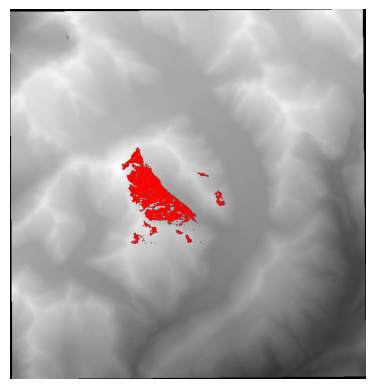

In [61]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 0/255, 0/255, 1])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)



plt.imshow(raster, cmap='gray')
show_mask(raster_snowmask, plt.gca())
plt.axis('scaled')
plt.axis('off')
plt.savefig('data/snow_segmented_DEM.png', bbox_inches='tight', dpi=300)
plt.show()